In [1]:
import pandas as pd
import numpy as np
import gzip

import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from keras.preprocessing.text import Tokenizer

/home/kai/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
itemID = 'asin'
userID = 'reviewerID'
rating = 'overall'
reviewText = 'reviewText'
timestamp = 'unixReviewTime'
keyPhrase = 'keyVector'
binary = 'Binary'
overall = 'overall'
num_keyPhrases = 100
dataPath = '../NCE_Projected_LRec/data/amazon/raw/'
dataName = 'reviews_CDs_and_Vinyl_5'
dataExtension = '.json.gz'

# Load Dataset

In [3]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF(dataPath+dataName+dataExtension)[[userID, itemID, reviewText, rating, timestamp]]
df[reviewText] = df[reviewText].astype('str')
df[userID] = df[userID].astype('str')
df[itemID] = df[itemID].astype('str')

In [4]:
def filter_dataset(df, threshold=3, popularity=True, filter_by_review_count=True, 
                   user_review_threshold=10, item_review_threshold=10, 
                   num_user=None, num_item=None, user_ratio=0.25, item_ratio=0.2):
    df[binary] = (df[rating] > threshold)*1

    df = df[df[binary] == 1]
    
    print("The total number of users is {}".format(df[userID].nunique()))
    print("The total number of items is {} \n".format(df[itemID].nunique()))
    

    values = df[itemID].value_counts().keys().tolist()
    counts = df[itemID].value_counts().tolist()
    item_df = pd.DataFrame.from_dict({itemID: values, "count": counts})
    
    values = df[userID].value_counts().keys().tolist()
    counts = df[userID].value_counts().tolist()
    user_df = pd.DataFrame.from_dict({userID: values, "count": counts})
    
    if popularity:
        print("Filter dataset by popularity. \n")
        
        if filter_by_review_count:
            print("Filter dataset by review count. \n")
            
            filtered_item_df = item_df[item_df["count"] >= item_review_threshold]
            filtered_item_id = filtered_item_df[itemID].values
            
            filtered_user_df = user_df[user_df["count"] >= user_review_threshold]
            filtered_user_id = filtered_user_df[userID].values
            
        else:
            print("Filter dataset by user and item number. \n")
            filtered_item_id = item_df[itemID].unique()[:num_item]
            filtered_user_id = user_df[userID].unique()[:num_user]
            
    else:
        print("Filter dataset by sampling. \n")
        np.random.seed(8292)
        
        filtered_item_id = np.take(item_df[itemID].unique(), 
                                   indices=np.random.choice(len(item_df), int(item_ratio*len(item_df))))
        filtered_user_id = np.take(user_df[userID].unique(), 
                                   indices=np.random.choice(len(user_df), int(user_ratio*len(user_df))))
        
    df = df.loc[(df[userID].isin(filtered_user_id)) & (df[itemID].isin(filtered_item_id))]
    
    print("Number of User: {}".format(df[userID].nunique()))
    print("Number of Item: {}".format(df[itemID].nunique()))

    return df

In [5]:
filtered_df = filter_dataset(df, threshold=3, popularity=True, filter_by_review_count=False, 
                   user_review_threshold=10, item_review_threshold=10, 
                   num_user=6300, num_item=3600, user_ratio=0.25, item_ratio=0.2)

The total number of users is 75037
The total number of items is 64356 

Filter dataset by popularity. 

Filter dataset by user and item number. 

Number of User: 6033
Number of Item: 3600


In [6]:
filtered_df.head()

,reviewerID,asin,reviewText,overall,unixReviewTime,Binary
4,ACCH8EOML6FN5,0439893577,I have a stainless steel refrigerator therefor...,4.0,1399248000,1
5,A1EDPGHC9EYBUN,0439893577,this is a nice magnetic board for the kids to ...,3.0,1368662400,1
11,A5I03TZD4J96V,0439893577,Bought this board along with Melissa and Doug ...,5.0,1338422400,1
13,A11Q7PYQ87R5Y2,0439893577,sturdy and perfect for coffee table. magnets s...,5.0,1400889600,1
14,A3AJWITG95EY0Q,0439893577,We had purchased Melissa & Doug magnets & had ...,5.0,1308873600,1


In [7]:
def process_reviewText(df):

    # Process ReviewText
    df["review"] = df[reviewText].apply(lambda x: nltk.word_tokenize(x)+[' '])

    # Lowercase
    df["review"] = df["review"].apply(lambda text: [w.lower() for w in text])

    # Remove Punctuation
    table = str.maketrans('', '', string.punctuation)
    df["review"] = df["review"].apply(lambda text: [w.translate(table) for w in text])

    # Remove tokens that are not alphabetic
    df["review"] = df["review"].apply(lambda text: [w for w in text if w.isalpha()])

    # Remove Stopwords
    # Get english stopwords
    en_stopwords = set(stopwords.words('english'))
    df["review"] = df["review"].apply(lambda text: [w for w in text if w not in en_stopwords])
    
    return df

In [8]:
filtered_df = process_reviewText(filtered_df)

/home/kai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/kai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/home/kai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

In [9]:
filtered_df

,reviewerID,asin,reviewText,overall,unixReviewTime,Binary,review
4,ACCH8EOML6FN5,0439893577,I have a stainless steel refrigerator therefor...,4.0,1399248000,1,"[stainless, steel, refrigerator, therefore, mu..."
5,A1EDPGHC9EYBUN,0439893577,this is a nice magnetic board for the kids to ...,3.0,1368662400,1,"[nice, magnetic, board, kids, carry, around, p..."
11,A5I03TZD4J96V,0439893577,Bought this board along with Melissa and Doug ...,5.0,1338422400,1,"[bought, board, along, melissa, doug, wood, ma..."
13,A11Q7PYQ87R5Y2,0439893577,sturdy and perfect for coffee table. magnets s...,5.0,1400889600,1,"[sturdy, perfect, coffee, table, magnets, stic..."
14,A3AJWITG95EY0Q,0439893577,We had purchased Melissa & Doug magnets & had ...,5.0,1308873600,1,"[purchased, melissa, doug, magnets, made, went..."
15,A137TYEMD68CAQ,0439893577,We purchased this to go with the magnetic lett...,5.0,1261872000,1,"[purchased, go, magnetic, letters, animals, se..."
19,A1X3ESYZ79H59E,048645195X,This book contains 30 full page designs that a...,5.0,1241481600,1,"[book, contains, full, page, designs, beautifu..."
20,AKMEY1BSHSDG7,048645195X,Prepare to be swept away by the beauty of the ...,5.0,1212105600,1,"[prepare, swept, away, beauty, images, color, ..."
22,A2IB3CUVPRE28M,048645195X,Very nice for time destraction. Bought for my ...,5.0,1384905600,1,"[nice, time, destraction, bought, year, old, n..."
23,A1MPWLA14I9OWW,048645195X,"I can color right along with my grandchildren,...",5.0,1364256000,1,"[color, right, along, grandchildren, without, ..."


In [10]:
def process_review_word(df):
    word_review_df = df[[itemID, "review"]]

    # Expand words from pandas column to rows
    lens = [len(item) for item in word_review_df["review"]]
    word_review_df = pd.DataFrame({itemID : np.repeat(word_review_df[itemID].values, lens), 
                                   "word" : np.concatenate(word_review_df["review"].values)})

    df_word_index = pd.DataFrame.from_dict({"word": word_review_df.word.unique(), 
                                            "index": range(len(word_review_df.word.unique()))})
    
    return word_review_df, df_word_index

In [11]:
word_review_df, df_word_index = process_review_word(filtered_df)

In [12]:
word_review_df

,asin,word
0,0439893577,stainless
1,0439893577,steel
2,0439893577,refrigerator
3,0439893577,therefore
4,0439893577,much
5,0439893577,space
6,0439893577,son
7,0439893577,play
8,0439893577,magnet
9,0439893577,brought


In [13]:
df_word_index

,index,word
0,0,stainless
1,1,steel
2,2,refrigerator
3,3,therefore
4,4,much
5,5,space
6,6,son
7,7,play
8,8,magnet
9,9,brought


In [16]:
# Calculate PMI
def calculate_pmi(df, word_review_df, freq_filter=15):    
    # Calculate p(review)
    values = df[itemID].value_counts().keys().tolist()
    counts = df[itemID].value_counts().tolist()
    item_df = pd.DataFrame.from_dict({itemID: values, "count_asin": counts})
    item_df['p_y'] = item_df['count_asin'] /  item_df['count_asin'].sum()
    
    # Calculate p(word)
    values = word_review_df["word"].value_counts().keys().tolist()
    counts = word_review_df["word"].value_counts().tolist()
    word_df = pd.DataFrame.from_dict({"word": values, "count_word": counts})
    word_df['p_x'] = word_df['count_word'] /  word_df['count_word'].sum()
    
    # Calculate p(word, review)
    co_occur_df = word_review_df.groupby([itemID, "word"]).size().reset_index(name="co-occur")
    co_occur_df['p_xy'] = co_occur_df['co-occur'] /  co_occur_df['co-occur'].sum()

    word_review_df = pd.merge(word_review_df, word_df, on='word', how='left')
    word_review_df = pd.merge(word_review_df, item_df, on=itemID, how='left')
    word_review_df = pd.merge(word_review_df, co_occur_df, on=['asin', 'word'], how='left')
    
    # Calculate pmi between word and review 
    word_review_df["pmi"] = np.log(word_review_df.p_xy / (word_review_df.p_x * word_review_df.p_y))
    word_review_df = word_review_df.sort_values("pmi", ascending=False)
    
    if freq_filter is not None:
        # Apply frequency filter
        word_review_df = word_review_df[word_review_df["co-occur"] >= freq_filter]
    return word_review_df

In [17]:
word_review_df = calculate_pmi(filtered_df, word_review_df, freq_filter=15)

In [18]:
word_review_df

,asin,word,count_word,p_x,count_asin,p_y,co-occur,p_xy,pmi
1022867,B002IVFOC8,msr,18,0.000005,1,0.000017,16,0.000004,10.845281
1022612,B002IVFOC8,msr,18,0.000005,1,0.000017,16,0.000004,10.845281
1022628,B002IVFOC8,msr,18,0.000005,1,0.000017,16,0.000004,10.845281
1022555,B002IVFOC8,msr,18,0.000005,1,0.000017,16,0.000004,10.845281
1022723,B002IVFOC8,msr,18,0.000005,1,0.000017,16,0.000004,10.845281
1022712,B002IVFOC8,msr,18,0.000005,1,0.000017,16,0.000004,10.845281
1022744,B002IVFOC8,msr,18,0.000005,1,0.000017,16,0.000004,10.845281
1022692,B002IVFOC8,msr,18,0.000005,1,0.000017,16,0.000004,10.845281
1022781,B002IVFOC8,msr,18,0.000005,1,0.000017,16,0.000004,10.845281
1022791,B002IVFOC8,msr,18,0.000005,1,0.000017,16,0.000004,10.845281


In [19]:
def get_keyphrases(word_review_df, num_keyPhrases):
    # Get word type
    word_type_df = pd.DataFrame.from_dict({"word": [nltk.pos_tag([word]) for word in word_review_df.word.unique()]})

    word_type_df["type"] = word_type_df["word"].apply(lambda x: x[0][1])
    word_type_df["word"] = word_type_df["word"].apply(lambda x: x[0][0])

    word_review_df = pd.merge(word_review_df, word_type_df, on='word', how='left')

    keyphrases = word_review_df[word_review_df["type"].isin(('JJ', 'JJR', 'JJS'))].word.unique()
    
    print("Length of keyphrases: {}".format(len(keyphrases[:num_keyPhrases])))
    
    return pd.DataFrame.from_dict({"Phrases": keyphrases}), keyphrases[:num_keyPhrases]

In [20]:
df_keyphrases, keyphrases = get_keyphrases(word_review_df, num_keyPhrases)

Length of keyphrases: 100


In [21]:
df_keyphrases.head()

,Phrases
0,powertouch
1,pelican
2,appdrive
3,bumble
4,zooble


In [26]:
len(keyphrases)

100

In [27]:
def add_keyVector(df, keyphrases):
#     df["keyVector"] = df["review"].apply(lambda x: [1. if key in x else 0 for key in keyphrases])
    df[keyPhrase] = df["review"].apply(lambda x: [keyphrases.index(key) for key in keyphrases if key in x])
    df['keyphrases_indices_length'] = df[keyPhrase].str.len()
    return df

In [28]:
filtered_df = add_keyVector(filtered_df, list(keyphrases))

/home/kai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [29]:
filtered_df

,reviewerID,asin,reviewText,overall,unixReviewTime,Binary,review,keyVector,keyphrases_indices_length
4,ACCH8EOML6FN5,0439893577,I have a stainless steel refrigerator therefor...,4.0,1399248000,1,"[stainless, steel, refrigerator, therefore, mu...","[92, 96]",2
5,A1EDPGHC9EYBUN,0439893577,this is a nice magnetic board for the kids to ...,3.0,1368662400,1,"[nice, magnetic, board, kids, carry, around, p...","[70, 79]",2
11,A5I03TZD4J96V,0439893577,Bought this board along with Melissa and Doug ...,5.0,1338422400,1,"[bought, board, along, melissa, doug, wood, ma...","[41, 68, 73, 80, 92]",5
13,A11Q7PYQ87R5Y2,0439893577,sturdy and perfect for coffee table. magnets s...,5.0,1400889600,1,"[sturdy, perfect, coffee, table, magnets, stic...","[78, 80, 92]",3
14,A3AJWITG95EY0Q,0439893577,We had purchased Melissa & Doug magnets & had ...,5.0,1308873600,1,"[purchased, melissa, doug, magnets, made, went...",[],0
15,A137TYEMD68CAQ,0439893577,We purchased this to go with the magnetic lett...,5.0,1261872000,1,"[purchased, go, magnetic, letters, animals, se...","[71, 86]",2
19,A1X3ESYZ79H59E,048645195X,This book contains 30 full page designs that a...,5.0,1241481600,1,"[book, contains, full, page, designs, beautifu...",[92],1
20,AKMEY1BSHSDG7,048645195X,Prepare to be swept away by the beauty of the ...,5.0,1212105600,1,"[prepare, swept, away, beauty, images, color, ...",[81],1
22,A2IB3CUVPRE28M,048645195X,Very nice for time destraction. Bought for my ...,5.0,1384905600,1,"[nice, time, destraction, bought, year, old, n...","[79, 97]",2
23,A1MPWLA14I9OWW,048645195X,"I can color right along with my grandchildren,...",5.0,1364256000,1,"[color, right, along, grandchildren, without, ...",[],0


In [30]:
def add_user_item_index(df):
    user_df = pd.DataFrame.from_dict({userID: df[userID].unique(), 
                                      "UserIndex": range(len(df[userID].unique()))})
    item_df = pd.DataFrame.from_dict({itemID: df[itemID].unique(), 
                                      "ItemIndex": range(len(df[itemID].unique()))})
    df = pd.merge(df, user_df, on=userID, how='left')
    df = pd.merge(df, item_df, on=itemID, how='left')
    return df

In [31]:
filtered_df = add_user_item_index(filtered_df)

In [32]:
filtered_df

,reviewerID,asin,reviewText,overall,unixReviewTime,Binary,review,keyVector,keyphrases_indices_length,UserIndex,ItemIndex
0,ACCH8EOML6FN5,0439893577,I have a stainless steel refrigerator therefor...,4.0,1399248000,1,"[stainless, steel, refrigerator, therefore, mu...","[92, 96]",2,0,0
1,A1EDPGHC9EYBUN,0439893577,this is a nice magnetic board for the kids to ...,3.0,1368662400,1,"[nice, magnetic, board, kids, carry, around, p...","[70, 79]",2,1,0
2,A5I03TZD4J96V,0439893577,Bought this board along with Melissa and Doug ...,5.0,1338422400,1,"[bought, board, along, melissa, doug, wood, ma...","[41, 68, 73, 80, 92]",5,2,0
3,A11Q7PYQ87R5Y2,0439893577,sturdy and perfect for coffee table. magnets s...,5.0,1400889600,1,"[sturdy, perfect, coffee, table, magnets, stic...","[78, 80, 92]",3,3,0
4,A3AJWITG95EY0Q,0439893577,We had purchased Melissa & Doug magnets & had ...,5.0,1308873600,1,"[purchased, melissa, doug, magnets, made, went...",[],0,4,0
5,A137TYEMD68CAQ,0439893577,We purchased this to go with the magnetic lett...,5.0,1261872000,1,"[purchased, go, magnetic, letters, animals, se...","[71, 86]",2,5,0
6,A1X3ESYZ79H59E,048645195X,This book contains 30 full page designs that a...,5.0,1241481600,1,"[book, contains, full, page, designs, beautifu...",[92],1,6,1
7,AKMEY1BSHSDG7,048645195X,Prepare to be swept away by the beauty of the ...,5.0,1212105600,1,"[prepare, swept, away, beauty, images, color, ...",[81],1,7,1
8,A2IB3CUVPRE28M,048645195X,Very nice for time destraction. Bought for my ...,5.0,1384905600,1,"[nice, time, destraction, bought, year, old, n...","[79, 97]",2,8,1
9,A1MPWLA14I9OWW,048645195X,"I can color right along with my grandchildren,...",5.0,1364256000,1,"[color, right, along, grandchildren, without, ...",[],0,9,1


Total number of keyphrases hit is: 219204 

The ratio of keyphrases hit is: 3.798831949811968 



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbe7f9f2320>]],
      dtype=object)

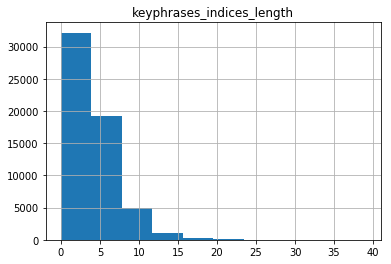

In [35]:
print("Total number of keyphrases hit is: {} \n".format(filtered_df['keyphrases_indices_length'].sum()))
print("The ratio of keyphrases hit is: {} \n".format(filtered_df['keyphrases_indices_length'].sum() / len(filtered_df)))
%matplotlib inline
filtered_df.hist(column='keyphrases_indices_length')

In [40]:
def export_data(df, df_word_index, df_keyphrases):
    df_user_name = df[['UserIndex',userID]]
    df_item_name = df[['ItemIndex',itemID]]
    
    print("Number of User: {0}".format(df_user_name['UserIndex'].nunique()))
    print("Number of Item: {0}".format(df_item_name['ItemIndex'].nunique()))
    print("Number of Positive Review: {0}".format(sum(df['Binary'].tolist())))
    print("Number of key Phrase: {0}".format(num_keyPhrases))
    print("Number of reviews: {0}".format(len(df)))
    
    df.to_csv(dataPath+'Data.csv')
    df_word_index.to_csv(dataPath+'WordIndex.csv')
    df_keyphrases.to_csv(dataPath+'KeyPhrases.csv')
    df_user_name.to_csv(dataPath+'UserIndex.csv')
    df_item_name.to_csv(dataPath+'ItemIndex.csv')

In [41]:
export_data(filtered_df, df_word_index, df_keyphrases)

Number of User: 4185
Number of Item: 5290
Number of Positive Review: 54132
Number of key Phrase: 100
Number of reviews: 57703


In [26]:
# Lemmatizing
lemmatizer = WordNetLemmatizer()
np.array_equal(np.array([lemmatizer.lemmatize(w) for w in keyphrases]), keyphrases)
# df["lem_token"] = df["token"].apply(lambda w: lemmatizer.lemmatize(w))

True

In [28]:
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()

np.array([porter.stem(word) for word in keyphrases])

array(['powertouch', 'pelican', 'appdriv', 'bumbl', 'zoobl', 'unicorn',
       'mudpuppi', 'decal', 'pictionari', 'golden', 'invis', 'attic',
       'bubbl', 'virtual', 'adject', 'scrabbl', 'inflat', 'ultra',
       'automat', 'gross', 'littlest', 'nest', 'puppi', 'live', 'aliv',
       'angri', 'american', 'adjust', 'music', 'ultim', 'black',
       'spanish', 'electron', 'number', 'recharg', 'hot', 'stabl',
       'origin', 'classic', 'white', 'true', 'compat', 'green',
       'interact', 'new', 'busi', 'separ', 'soft', 'free', 'sharp',
       'main', 'previou', 'high', 'regular', 'basic', 'educ', 'open',
       'short', 'tini', 'realist', 'flat', 'readi', 'real', 'clear',
       'next', 'easi', 'avail', 'red', 'creativ', 'differ', 'addit',
       'larg', 'safe', 'big', 'expens', 'difficult', 'best', 'bigger',
       'good', 'nice', 'older', 'small', 'bad', 'larger', 'interest',
       'easier', 'mani', 'younger', 'hard', 'durabl', 'last', 'abl',
       'great', 'extra', 'littl', 'yo

# Split by popularity, user, item count

In [147]:
filtered_df = filter_dataset(df, threshold=3, popularity=True, filter_by_review_count=True, 
                   user_review_threshold=23, item_review_threshold=40, 
                   num_user=None, num_item=None, user_ratio=0.25, item_ratio=0.2)

The total number of users is 75037
The total number of items is 64356 

Filter dataset by popularity. 

Filter dataset by review count. 

Number of User: 6134
Number of Item: 3865


# Split by popularity, user and item number

In [6]:
filtered_df = filter_dataset(df, threshold=3, popularity=True, filter_by_review_count=False, 
                   user_review_threshold=10, item_review_threshold=10, 
                   num_user=6300, num_item=3600, user_ratio=0.25, item_ratio=0.2)

The total number of users is 75037
The total number of items is 64356 

Filter dataset by popularity. 

Filter dataset by user and item number. 

Number of User: 6033
Number of Item: 3600


In [7]:
filtered_df

,reviewerID,asin,reviewText,overall,unixReviewTime,Binary
232,A2GANR9I6XHTU9,0780018664,Filmed in 1931 this is the first serial killer...,4.0,1169337600,1
233,ANCOMAI0I7LVG,0780018664,My feelings for this iconic piece of filmmakin...,5.0,1213574400,1
234,A1GGOC9PVDXW7Z,0780018664,The title M comes from a chalk mark (for 'murd...,5.0,1268524800,1
236,A62G4QX6XQVLP,0780018664,This film is easily in the Top 5 of Fritz Lang...,5.0,1165190400,1
237,A2ILOYARQVO4K1,0780018664,"Dark, disturbingly satirical, humorous exactly...",4.0,989193600,1
238,A2XKQHB8VCUCJK,0780018664,&#34;M&#34; is a German expressionist film dir...,5.0,1385942400,1
239,AEBOD21JROJ4G,0780018664,I've just now (minutes ago) finished seeing th...,5.0,1105660800,1
240,AIMR915K4YCN,0780018664,"While watching this story unfold, I found myse...",5.0,1083196800,1
241,A2CW9IQAPFEYLM,0780018664,Peter Lorre is the psychopathic child murderer...,5.0,1129334400,1
244,A1GHUN5HXMHZ89,0780018664,"I don't know if it is in writing somewhere, bu...",5.0,1300406400,1


In [148]:
filtered_df = filtered_df[[userID, itemID, rating, timestamp]].reset_index(drop=True)

filtered_df.to_csv(dataPath+dataName+".csv", header=False)

In [83]:
filtered_df

,reviewerID,asin,reviewText,overall,unixReviewTime,Binary
232,A2GANR9I6XHTU9,0780018664,Filmed in 1931 this is the first serial killer...,4.0,1169337600,1
233,ANCOMAI0I7LVG,0780018664,My feelings for this iconic piece of filmmakin...,5.0,1213574400,1
234,A1GGOC9PVDXW7Z,0780018664,The title M comes from a chalk mark (for 'murd...,5.0,1268524800,1
236,A62G4QX6XQVLP,0780018664,This film is easily in the Top 5 of Fritz Lang...,5.0,1165190400,1
237,A2ILOYARQVO4K1,0780018664,"Dark, disturbingly satirical, humorous exactly...",4.0,989193600,1
238,A2XKQHB8VCUCJK,0780018664,&#34;M&#34; is a German expressionist film dir...,5.0,1385942400,1
239,AEBOD21JROJ4G,0780018664,I've just now (minutes ago) finished seeing th...,5.0,1105660800,1
240,AIMR915K4YCN,0780018664,"While watching this story unfold, I found myse...",5.0,1083196800,1
241,A2CW9IQAPFEYLM,0780018664,Peter Lorre is the psychopathic child murderer...,5.0,1129334400,1
244,A1GHUN5HXMHZ89,0780018664,"I don't know if it is in writing somewhere, bu...",5.0,1300406400,1


In [142]:
values = filtered_df[userID].value_counts().keys().tolist()
counts = filtered_df[userID].value_counts().tolist()
user_df = pd.DataFrame.from_dict({userID: values, "count": counts})

values = filtered_df[itemID].value_counts().keys().tolist()
counts = filtered_df[itemID].value_counts().tolist()
item_df = pd.DataFrame.from_dict({itemID: values, "count": counts})

In [143]:
# item_df[item_df["count"] == 9]
item_df

,asin,count
0,B000000IRB,302
1,B000002UB2,274
2,B000002UAT,264
3,B000002UAR,247
4,B000002UAX,245
5,B00004ZAV3,219
6,B000002J09,210
7,B000002H33,208
8,B000002JS6,196
9,B000000IV0,195


In [144]:
item_df["count"].mean()

34.03260025873221

In [145]:
# user_df[user_df["count"] == 9]
user_df

,count,reviewerID
0,555,A3KJ6JAZPH382D
1,468,A1GN8UJIZLCA59
2,442,A1J5KCZC8CMW9I
3,391,A3HU0B9XUEVHIM
4,387,A2582KMXLK2P06
5,382,A34Y1FT0MTD7C9
6,379,A26NLSTT75FMJM
7,361,ASVNSWIXBV72Q
8,340,A12R54MKO17TW0
9,326,A1QEWOSV05RYEO


In [146]:
user_df["count"].mean()

21.443756113465927

In [64]:
filtered_df[filtered_df["Binary"] == 1]

,reviewerID,asin,reviewText,overall,unixReviewTime,Binary
232,A2GANR9I6XHTU9,0780018664,Filmed in 1931 this is the first serial killer...,4.0,1169337600,1
233,ANCOMAI0I7LVG,0780018664,My feelings for this iconic piece of filmmakin...,5.0,1213574400,1
234,A1GGOC9PVDXW7Z,0780018664,The title M comes from a chalk mark (for 'murd...,5.0,1268524800,1
236,A62G4QX6XQVLP,0780018664,This film is easily in the Top 5 of Fritz Lang...,5.0,1165190400,1
237,A2ILOYARQVO4K1,0780018664,"Dark, disturbingly satirical, humorous exactly...",4.0,989193600,1
238,A2XKQHB8VCUCJK,0780018664,&#34;M&#34; is a German expressionist film dir...,5.0,1385942400,1
239,AEBOD21JROJ4G,0780018664,I've just now (minutes ago) finished seeing th...,5.0,1105660800,1
240,AIMR915K4YCN,0780018664,"While watching this story unfold, I found myse...",5.0,1083196800,1
241,A2CW9IQAPFEYLM,0780018664,Peter Lorre is the psychopathic child murderer...,5.0,1129334400,1
244,A1GHUN5HXMHZ89,0780018664,"I don't know if it is in writing somewhere, bu...",5.0,1300406400,1


# Sampling

In [85]:
filtered_df, item_df = filter_dataset(df, threshold=3, popularity=False, filter_by_review_count=False, 
                   user_review_threshold=10, item_review_threshold=10, 
                   num_user=4000, num_item=5000, user_ratio=0.25, item_ratio=0.7)

The total number of users is 19412
The total number of items is 11924 

Filter dataset by sampling. 

Number of User: 4212
Number of Item: 5158


In [86]:
filtered_df.to_csv(dataPath+'Data.csv')

In [61]:
# # Lemmatizing
# lemmatizer = WordNetLemmatizer()
# df["lem_token"] = df["token"].apply(lambda w: lemmatizer.lemmatize(w))

In [77]:
word_review_df[word_review_df["type"].isin(('JJ', 'JJR', 'JJS'))].word.unique()

array(['powertouch', 'pelican', 'appdrive', 'zooble', 'bumble',
       'inflatable', 'adjective', 'unicorn', 'mudpuppy', 'decal',
       'pictionary', 'golden', 'invisible', 'attic', 'nest', 'bubble',
       'virtual', 'scrabble', 'spanish', 'littlest', 'ultra', 'gross',
       'automatic', 'american', 'ultimate', 'adjustable', 'puppy',
       'stable', 'live', 'alive', 'angry', 'musical', 'compatible',
       'black', 'previous', 'sharp', 'electronic', 'numbered',
       'rechargeable', 'red', 'hot', 'tiny', 'regular', 'separate',
       'available', 'main', 'safe', 'green', 'bigger', 'realistic',
       'true', 'white', 'busy', 'larger', 'original', 'classic', 'flat',
       'clear', 'free', 'high', 'basic', 'bad', 'interactive', 'new',
       'additional', 'overall', 'next', 'soft', 'young', 'ready', 'open',
       'real', 'expensive', 'interested', 'educational', 'easier',
       'short', 'extra', 'creative', 'last', 'older', 'large',
       'difficult', 'best', 'happy', 'small', '

In [78]:
len(word_review_df[word_review_df["type"].isin(('JJ', 'JJR', 'JJS'))].word.unique())

101

In [79]:
# Lemmatizing
lemmatizer = WordNetLemmatizer()
np.array([lemmatizer.lemmatize(w) for w in word_review_df[word_review_df["type"].isin(('JJ', 'JJR', 'JJS'))].word.unique()])

array(['powertouch', 'pelican', 'appdrive', 'zooble', 'bumble',
       'inflatable', 'adjective', 'unicorn', 'mudpuppy', 'decal',
       'pictionary', 'golden', 'invisible', 'attic', 'nest', 'bubble',
       'virtual', 'scrabble', 'spanish', 'littlest', 'ultra', 'gross',
       'automatic', 'american', 'ultimate', 'adjustable', 'puppy',
       'stable', 'live', 'alive', 'angry', 'musical', 'compatible',
       'black', 'previous', 'sharp', 'electronic', 'numbered',
       'rechargeable', 'red', 'hot', 'tiny', 'regular', 'separate',
       'available', 'main', 'safe', 'green', 'bigger', 'realistic',
       'true', 'white', 'busy', 'larger', 'original', 'classic', 'flat',
       'clear', 'free', 'high', 'basic', 'bad', 'interactive', 'new',
       'additional', 'overall', 'next', 'soft', 'young', 'ready', 'open',
       'real', 'expensive', 'interested', 'educational', 'easier',
       'short', 'extra', 'creative', 'last', 'older', 'large',
       'difficult', 'best', 'happy', 'small', '

In [37]:
word_review_df[word_review_df["type"].isin(('JJ', 'JJR', 'JJS'))].word.unique()

array(['pelican', 'appdrive', 'bumble', 'unicorn', 'decal', 'pictionary',
       'invisible', 'attic', 'nest', 'bubble', 'virtual', 'scrabble',
       'littlest', 'ultra', 'gross', 'american', 'puppy', 'stable',
       'live', 'alive', 'angry', 'musical', 'compatible', 'black',
       'previous', 'sharp', 'electronic', 'numbered', 'rechargeable',
       'red', 'hot', 'tiny', 'available', 'green', 'realistic', 'true',
       'white', 'busy', 'original', 'classic', 'free', 'high', 'basic',
       'interactive', 'new', 'next', 'soft', 'open', 'real', 'expensive',
       'educational', 'easier', 'short', 'older', 'large', 'best',
       'happy', 'small', 'different', 'easy', 'able', 'younger', 'much',
       'good', 'durable', 'big', 'hard', 'nice', 'many', 'little',
       'great', 'old'], dtype=object)

In [40]:
len(word_review_df[word_review_df["type"].isin(('JJ', 'JJR', 'JJS'))].word.unique())

72

In [39]:
# Lemmatizing
lemmatizer = WordNetLemmatizer()
np.array([lemmatizer.lemmatize(w) for w in word_review_df[word_review_df["type"].isin(('JJ', 'JJR', 'JJS'))].word.unique()])

array(['pelican', 'appdrive', 'bumble', 'unicorn', 'decal', 'pictionary',
       'invisible', 'attic', 'nest', 'bubble', 'virtual', 'scrabble',
       'littlest', 'ultra', 'gross', 'american', 'puppy', 'stable',
       'live', 'alive', 'angry', 'musical', 'compatible', 'black',
       'previous', 'sharp', 'electronic', 'numbered', 'rechargeable',
       'red', 'hot', 'tiny', 'available', 'green', 'realistic', 'true',
       'white', 'busy', 'original', 'classic', 'free', 'high', 'basic',
       'interactive', 'new', 'next', 'soft', 'open', 'real', 'expensive',
       'educational', 'easier', 'short', 'older', 'large', 'best',
       'happy', 'small', 'different', 'easy', 'able', 'younger', 'much',
       'good', 'durable', 'big', 'hard', 'nice', 'many', 'little',
       'great', 'old'], dtype='<U12')